In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [92]:
mobile_sales = pd.read_excel('mobilesales.xlsx', engine='openpyxl')
mobile_sales.head()

,DATE,Sales
0,2001-01-01,6519.0
1,2001-02-01,6654.0
2,2001-03-01,7332.0
3,2001-04-01,7332.0
4,2001-05-01,8240.0


In [93]:
# In TimeSeries it is good to have the date as index
mobile_sales.set_index('DATE', inplace=True)
mobile_sales.head()

,Sales
DATE,
2001-01-01,6519.0
2001-02-01,6654.0
2001-03-01,7332.0
2001-04-01,7332.0
2001-05-01,8240.0


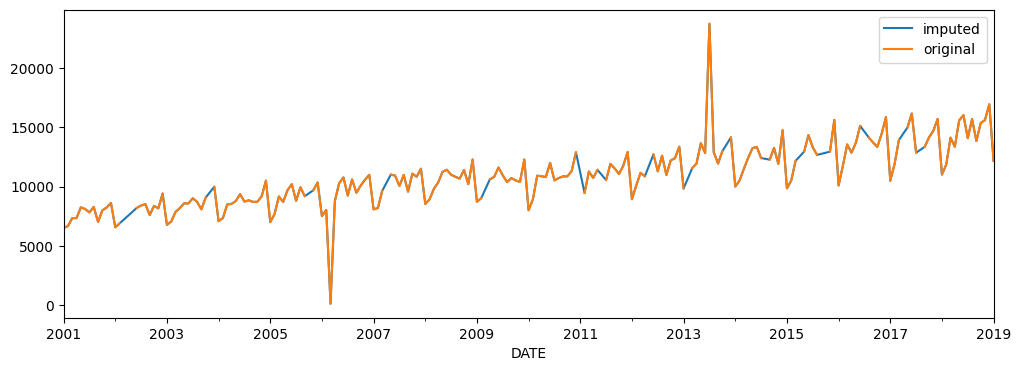

In [94]:
mobile_sales.Sales.interpolate(method='linear').plot(label='imputed')
mobile_sales.Sales.plot(label='original', figsize=(12,4))
plt.legend()

In [95]:
mobile_sales.Sales = mobile_sales.Sales.interpolate(method='linear')

<Axes: xlabel='DATE'>

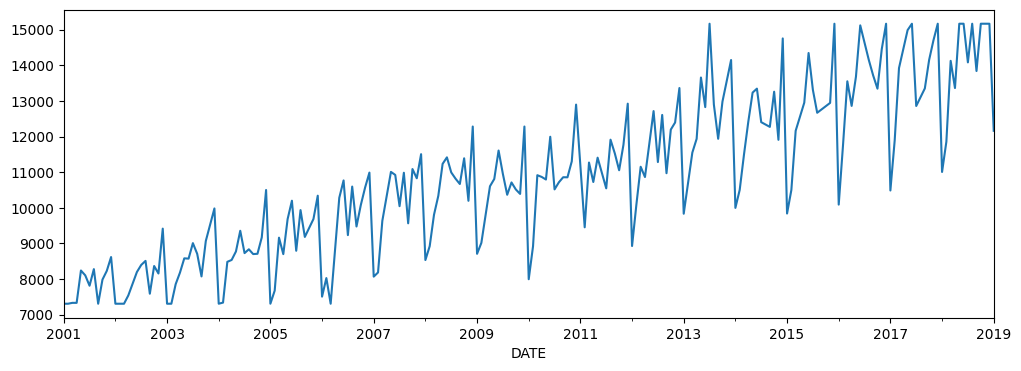

In [96]:
mobile_sales.Sales.clip(lower=mobile_sales.Sales.quantile(0.05), upper=mobile_sales.Sales.quantile(0.95)).plot(figsize=(12,4))

In [97]:
## let's take last 12 months as test data
train_max_date = mobile_sales.index[-12]
train_max_date

Timestamp('2018-02-01 00:00:00')

In [98]:
train_x = mobile_sales.loc[mobile_sales.index < mobile_sales.index[-12]].copy()
test_x = mobile_sales.loc[mobile_sales.index >= mobile_sales.index[-12]].copy()

In [99]:
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae,
    mean_absolute_percentage_error as mape
)


### Creating function to measure and print all three metric
def performance(actual, predicted):
    print('MAE :', round(mae(actual, predicted), 3))
    print('RMSE :', round(mse(actual, predicted)**0.5, 3))
    print('MAPE:', round(mape(actual, predicted), 3))

performance([100], [98])

MAE : 2.0
RMSE : 2.0
MAPE: 0.02


#### Simple Naive Test
- Taking mean of previous values and forecasting

MAE : 3546.167
RMSE : 3854.067
MAPE: 0.235


C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_20364\393788180.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_x['pred'] = train_x['Sales'][-1]


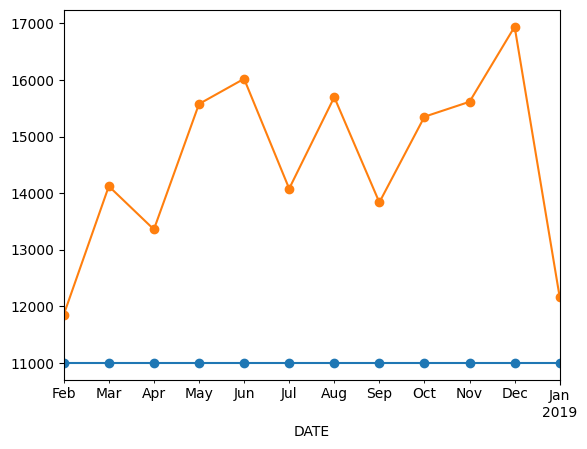

In [100]:
preds = train_x['Sales'].mean()

test_x['pred'] = preds
train_x['pred'] = preds


test_x['pred'] = train_x['Sales'][-1]
test_x['pred'].plot(label="mean_preds", style= '-o')
test_x['Sales'].plot(label='original', style='-o')
performance(test_x['Sales'], test_x['pred'])

### Naive Seasonal
- Taking average for last period of time values mean to forecast

In [101]:
for i in test_x.index:
    test_x.loc[i]['pred'] = train_x.loc[i-pd.DateOffset(years=1)]['Sales']

test_x

C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_20364\2693251892.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_x.loc[i]['pred'] = train_x.loc[i-pd.DateOffset(years=1)]['Sales']


,Sales,pred
DATE,,
2018-02-01,11852.0,11005.0
2018-03-01,14123.0,11005.0
2018-04-01,13360.0,11005.0
2018-05-01,15576.0,11005.0
2018-06-01,16021.0,11005.0
2018-07-01,14080.0,11005.0
2018-08-01,15697.0,11005.0
2018-09-01,13838.0,11005.0
2018-10-01,15351.0,11005.0


In [102]:
test_x['pred']=train_x.iloc[-12:]['Sales'].values
test_x

,Sales,pred
DATE,,
2018-02-01,11852.0,11891.0
2018-03-01,14123.0,13921.0
2018-04-01,13360.0,14453.5
2018-05-01,15576.0,14986.0
2018-06-01,16021.0,16168.0
2018-07-01,14080.0,12856.0
2018-08-01,15697.0,13102.5
2018-09-01,13838.0,13349.0
2018-10-01,15351.0,14150.0


MAE : 907.417
RMSE : 1126.351
MAPE: 0.062


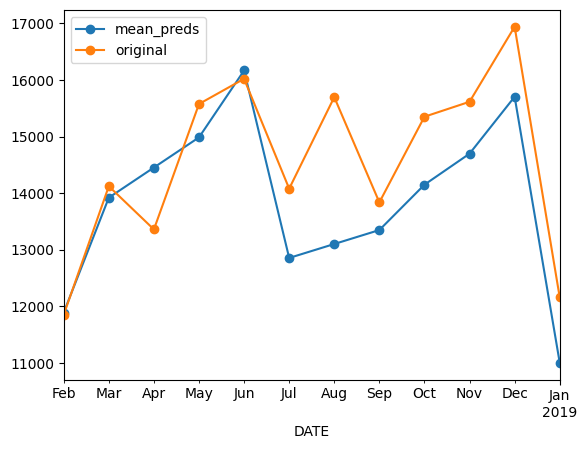

In [103]:
test_x['pred'].plot(label="mean_preds", style= '-o')
test_x['Sales'].plot(label='original', style='-o')
performance(test_x['Sales'], test_x['pred'])
plt.legend()

### Drift Method

<Axes: xlabel='DATE'>

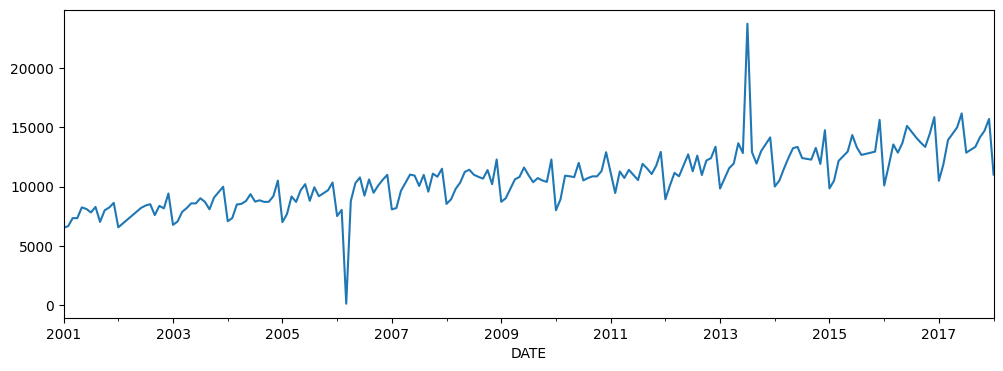

In [104]:
train_x.Sales.plot(label='original', figsize = (12,4))

In [105]:
# Get the slope: (last_value - first_value)/Total_values
y_t = train_x['Sales'][-1]
m = (y_t - train_x['Sales'][0]) / len(train_x)
m

C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_20364\977195124.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_t = train_x['Sales'][-1]
C:\Users\FPK1COB\AppData\Local\Temp\ipykernel_20364\977195124.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = (y_t - train_x['Sales'][0]) / len(train_x)


np.float64(21.882926829268293)

In [106]:
import numpy as np

#create h
h = np.linspace(0,len(test_x)-1, len(test_x))

##
h = np.array(range(1,len(test_x)+1))
h

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

MAE : 3403.928
RMSE : 3714.942
MAPE: 0.225


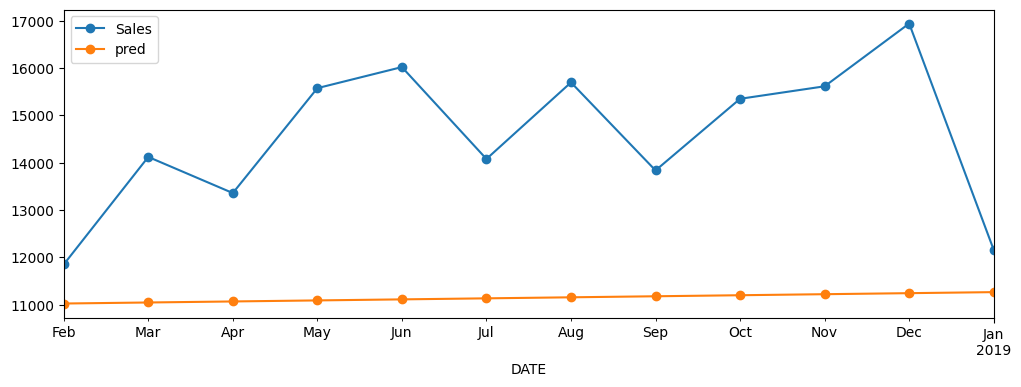

In [107]:
test_x['pred'] = y_t + m * h

test_x.plot(style='-o', figsize = (12,4))

performance(test_x['Sales'], test_x['pred'])

**MAPE** is 22% not good forecasting

#### Moving Average

In [108]:
import numpy as np

df = mobile_sales.copy()

In [109]:
df.tail()

,Sales
DATE,
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0
2018-12-01,16941.0
2019-01-01,12160.0


MS - means month starting in frequency parameter

In [110]:
pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=12,freq='MS')) 

""
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01


In [111]:
df_with_dates = pd.DataFrame(index = pd.date_range(start=df.index[-1], periods=13,freq='MS')) 
df_with_dates

""
2019-01-01
2019-02-01
2019-03-01
2019-04-01
2019-05-01
2019-06-01
2019-07-01
2019-08-01
2019-09-01
2019-10-01


**Note:**
- periods =13 because we want to predict 12 months after the last date in train data, 
- if it is 12 then it will include the last date of train data also, so we take 13 and 
- in next step we will remove the first date
- In order to take care of this, we need to explicitly mention that we want values from the second index of the result of `pd.date_range()`
- Hence Before adding this into dataframe slice the Series by `[1:]`

In [112]:
df = pd.concat([df , df_with_dates[1:]])
df.tail(20)

,Sales
2018-06-01,16021.0
2018-07-01,14080.0
2018-08-01,15697.0
2018-09-01,13838.0
2018-10-01,15351.0
2018-11-01,15615.0
2018-12-01,16941.0
2019-01-01,12160.0
2019-02-01,NaN
2019-03-01,NaN


In [113]:
pred = df.Sales.dropna().values

In [114]:
pred

array([ 6519.        ,  6654.        ,  7332.        ,  7332.        ,
        8240.        ,  8104.        ,  7813.        ,  8279.        ,
        7014.        ,  7985.        ,  8229.        ,  8618.        ,
        6558.        ,  6882.        ,  7211.        ,  7540.        ,
        7869.        ,  8198.        ,  8396.        ,  8510.        ,
        7589.        ,  8366.        ,  8156.        ,  9415.        ,
        6765.        ,  7048.        ,  7856.        ,  8181.        ,
        8581.        ,  8573.        ,  9008.        ,  8708.        ,
        8074.        ,  9068.        ,  9524.5       ,  9981.        ,
        7071.        ,  7339.        ,  8483.        ,  8536.        ,
        8774.        ,  9355.        ,  8728.        ,  8835.        ,
        8701.        ,  8709.        ,  9170.        , 10499.        ,
        6994.        ,  7675.        ,  9161.        ,  8699.        ,
        9682.        , 10198.        ,  8794.        ,  9935.        ,
      

In [115]:
for i in range(12):
    pred = np.append(pred, pred[-3:].mean())

In [116]:
pred[-20:]

array([16021.        , 14080.        , 15697.        , 13838.        ,
       15351.        , 15615.        , 16941.        , 12160.        ,
       14905.33333333, 14668.77777778, 13911.37037037, 14495.16049383,
       14358.43621399, 14254.98902606, 14369.52857796, 14327.65127267,
       14317.38962557, 14338.1898254 , 14327.74357455, 14327.77434184])

In [117]:
df['Pred'] = pred

In [118]:
df.tail(20)

,Sales,Pred
2018-06-01,16021.0,16021.000000
2018-07-01,14080.0,14080.000000
2018-08-01,15697.0,15697.000000
2018-09-01,13838.0,13838.000000
2018-10-01,15351.0,15351.000000
2018-11-01,15615.0,15615.000000
2018-12-01,16941.0,16941.000000
2019-01-01,12160.0,12160.000000
2019-02-01,NaN,14905.333333
2019-03-01,NaN,14668.777778


In [119]:
df['Sales'].isna()

2001-01-01    False
2001-02-01    False
2001-03-01    False
2001-04-01    False
2001-05-01    False
              ...  
2019-09-01     True
2019-10-01     True
2019-11-01     True
2019-12-01     True
2020-01-01     True
Name: Sales, Length: 229, dtype: bool

In [120]:
df.loc[~df['Sales'].isna(), 'Pred']

2001-01-01     6519.0
2001-02-01     6654.0
2001-03-01     7332.0
2001-04-01     7332.0
2001-05-01     8240.0
               ...   
2018-09-01    13838.0
2018-10-01    15351.0
2018-11-01    15615.0
2018-12-01    16941.0
2019-01-01    12160.0
Name: Pred, Length: 217, dtype: float64

In [121]:
df.loc[~df['Sales'].isna(), 'Pred'] = np.nan

In [122]:
df

,Sales,Pred
2001-01-01,6519.0,NaN
2001-02-01,6654.0,NaN
2001-03-01,7332.0,NaN
2001-04-01,7332.0,NaN
2001-05-01,8240.0,NaN
...,...,...
2019-09-01,NaN,14327.651273
2019-10-01,NaN,14317.389626
2019-11-01,NaN,14338.189825
2019-12-01,NaN,14327.743575


<Axes: >

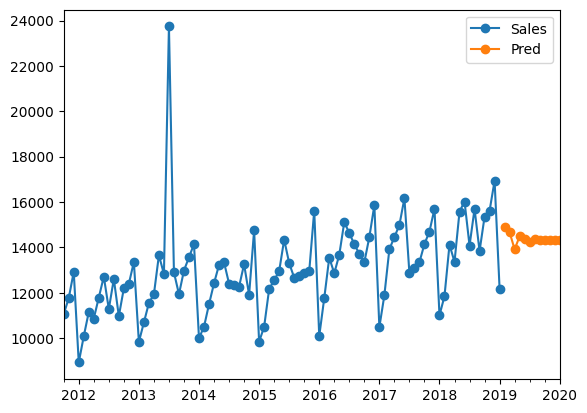

In [123]:
df.tail(100).plot(style='-o')

MAE : 1804.4
RMSE : 2052.51
MAPE: 0.121


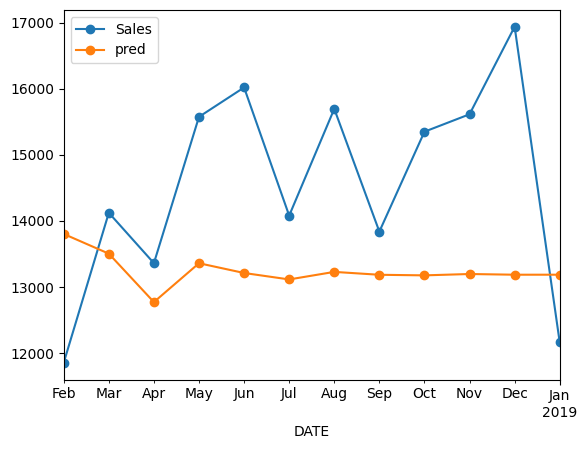

In [124]:
## Moving Average in single cell

df = train_x.copy()

df = pd.concat([df, pd.DataFrame(index=pd.date_range(start=df.index[-1], periods=13, freq='MS')[1:])])

pred = df.Sales.dropna().values

for i in range(12):
    pred = np.append(pred, pred[-3:].mean())

test_x['pred'] = pred[-12:]
test_x.plot(style='-o')
performance(test_x['Sales'], test_x['pred'])

**MAPE** - it is 11% more than 5%, still not good

## Exponential Smoothing Average (Holt's Winter Models)

- Simple Exponential Smoothing Avg (Suitable for Data with no trends and no seasonality)
- Double Exponential Smoothing Avg (Suitable for Data with trends and noseasonality)
- Triple Exponential Smoothing Avg (Suitable for Data with both trends and seasonality)

### Simple Exponential Smoothing


c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


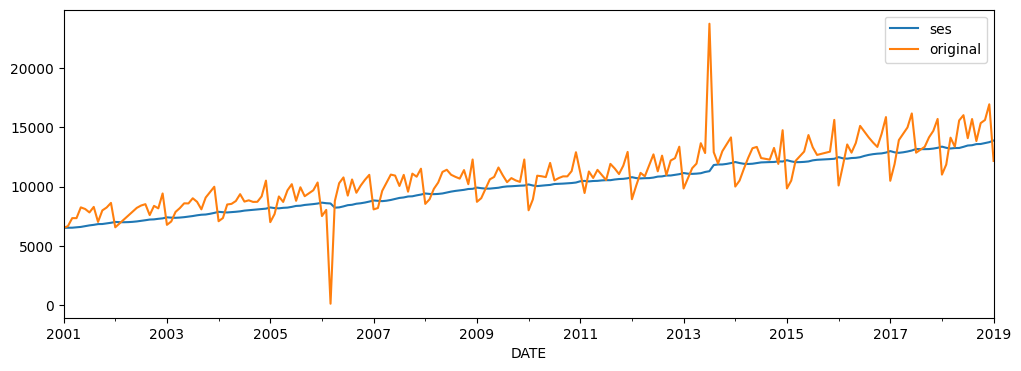

In [125]:
import statsmodels.api as sm

model = sm.tsa.SimpleExpSmoothing(mobile_sales.Sales).fit(smoothing_level=1/(2*12))
levels = pd.Series(model.fittedvalues)

levels.plot(label='ses', figsize=(12,4))
mobile_sales.Sales.plot(label='original')
plt.legend()

Smoothing level best can be 
1/(2*Seasonality-window) -- here seasonality window is 12months

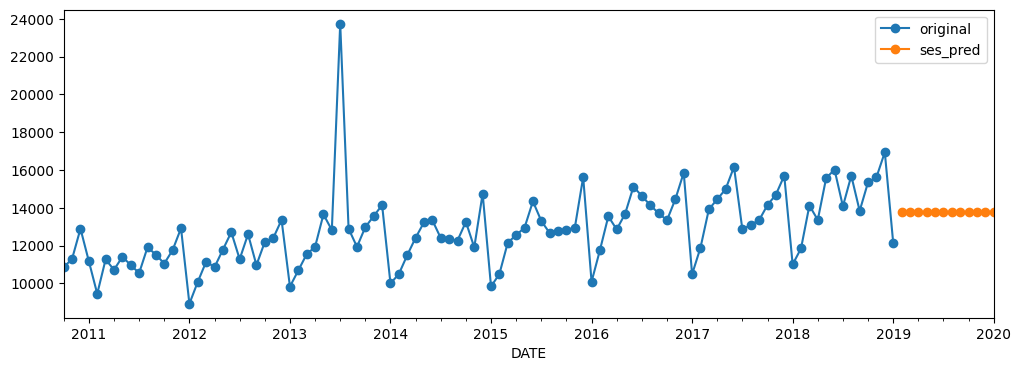

In [126]:
pred_test = model.forecast(steps = 12)

mobile_sales.Sales.tail(100).plot(label='original', style='-o')

pred_test.plot(label='ses_pred', style='-o',figsize=(12,4))
plt.legend()

MAE : 1703.587
RMSE : 1980.934
MAPE: 0.113


c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\pandas\util\_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


<Axes: xlabel='DATE'>

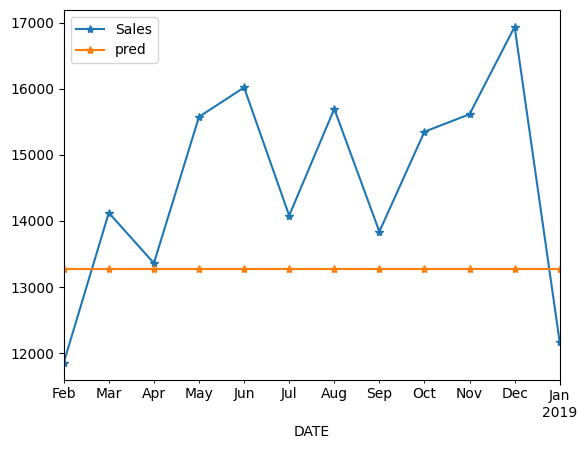

In [127]:
## Comparing Train and Test Performance
model = sm.tsa.SimpleExpSmoothing(train_x.Sales).fit(smoothing_level=1/(2*12))
predict_test = model.forecast(steps = 12)
test_x['pred'] = predict_test.values
performance(test_x['Sales'], test_x['pred'])
test_x.plot(style = '-*')

### Dual Exponential Smoothing

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


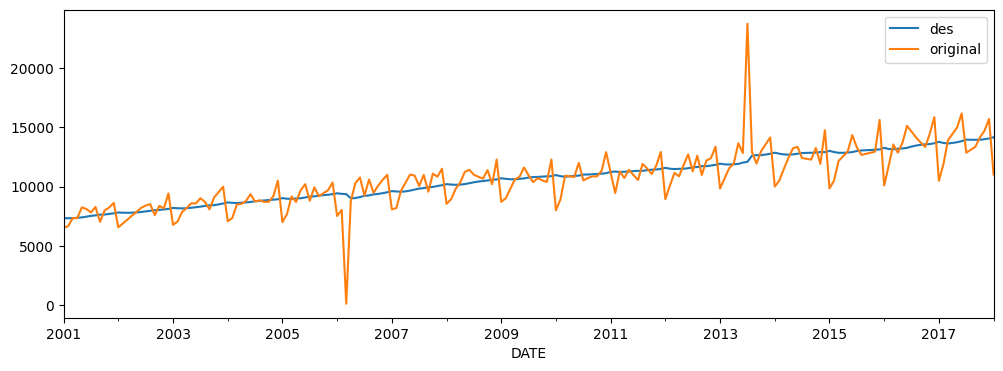

In [128]:
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))

levels = pd.Series(model.fittedvalues)
levels.plot(label='des', figsize=(12,4))
train_x.Sales.plot(label='original')
plt.legend()

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


MAE : 1282.947
RMSE : 1511.504
MAPE: 0.089


<Axes: xlabel='DATE'>

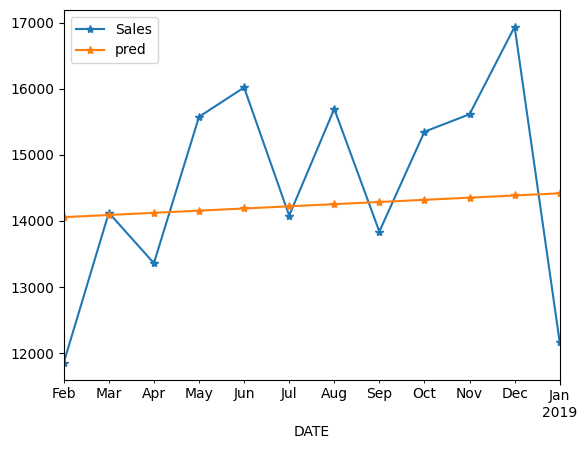

In [129]:
## performance
model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add').fit(smoothing_level=1/(2*12))
predict_test = model.forecast(steps = 12)

test_x['pred'] = predict_test.values
performance(test_x['Sales'], test_x['pred'])
test_x.plot(style = '-*')

### Triple Exponential Smoothing (TES)

c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


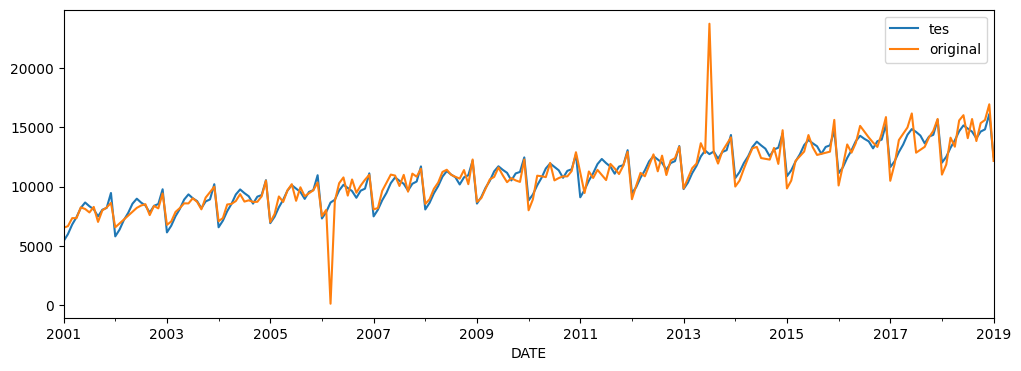

In [130]:
model = sm.tsa.ExponentialSmoothing(mobile_sales.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))

level = pd.Series(model.fittedvalues)
level.plot(label='tes', figsize=(12,4))
mobile_sales.Sales.plot(label='original')
plt.legend()

MAE : 761.444
RMSE : 816.911
MAPE: 0.051


c:\Users\FPK1COB\Documents\Learning\TimeSeries\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: xlabel='DATE'>

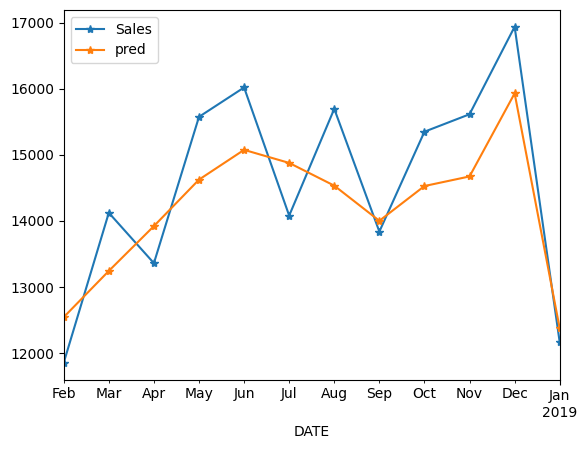

In [132]:
### performance

model = sm.tsa.ExponentialSmoothing(train_x.Sales, trend='add', seasonal='add').fit(smoothing_level=1/(2*12))

predict_test = model.forecast(steps = 12)
test_x['pred'] = predict_test.values
performance(test_x['Sales'], test_x['pred'])
test_x.plot(style = '-*')